# Generate Trade-off Curves - Stock + Emission - Loop

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
# Install Pandas Library Version 2.0.3
%pip install pandas==2.0.3

Note: you may need to restart the kernel to use updated packages.


In [3]:
# Install libcbm Module from GitHub and Import it
install_libcbm = False
if install_libcbm:
    %pip install -U git+https://github.com/cat-cfs/libcbm_py.git@main
    import libcbm
    libcbm.__path__

In [4]:
# Import Modules
import matplotlib.pyplot as plt
import pandas as pd
import ws3.forest, ws3.core
import math
import libcbm
import os

In [5]:
from util import compile_scenario, plot_scenario, plugin_c_curves

In [6]:
#Install Module
%pip install gurobipy
#Import Module
import gurobipy as grb

Note: you may need to restart the kernel to use updated packages.


In [7]:
#Define constants from product carbon estimation
# Define the product half-lives（>0.69)
half_life_solid_wood = 60
half_life_paper = 2
# Define the allocation distribution
proportion_solid_wood = 1
# Define the untilization rate
util = 0.85
# Define the HWPs displacement factor 
displacement_factor_solid = 1.5
# Define the Credibility
credit =  1.0

In [8]:
# Define base folder path
base_dir = 'results/trade_off/curves/'

In [9]:
# Define Disturance Types
disturbance_type_mapping = [{'user_dist_type': 'harvest', 'default_dist_type': 'Clearcut harvesting without salvage'},
                            {'user_dist_type': 'fire', 'default_dist_type': 'Wildfire'}]

In [10]:
# Define Carbon Pools
biomass_pools = ['SoftwoodMerch','SoftwoodFoliage', 'SoftwoodOther', 'SoftwoodCoarseRoots','SoftwoodFineRoots',                        
                 'HardwoodMerch', 'HardwoodFoliage', 'HardwoodOther', 'HardwoodCoarseRoots', 'HardwoodFineRoots']
dom_pools = ['AboveGroundVeryFastSoil', 'BelowGroundVeryFastSoil', 'AboveGroundFastSoil', 'BelowGroundFastSoil',
             'MediumSoil', 'AboveGroundSlowSoil', 'BelowGroundSlowSoil', 'SoftwoodStemSnag', 'SoftwoodBranchSnag',
             'HardwoodStemSnag', 'HardwoodBranchSnag']
emissions_pools = ['CO2', 'CH4', 'CO', 'NO2']
products_pools = ['Products']
ecosystem_pools = biomass_pools + dom_pools
all_pools = biomass_pools + dom_pools + emissions_pools + products_pools

# Define Carbon Fluxes
annual_process_fluxes = [
    'DecayDOMCO2Emission',
    'DeltaBiomass_AG',
    'DeltaBiomass_BG',
    'TurnoverMerchLitterInput',
    'TurnoverFolLitterInput',
    'TurnoverOthLitterInput',
    'TurnoverCoarseLitterInput',
    'TurnoverFineLitterInput',
    'DecayVFastAGToAir',
    'DecayVFastBGToAir',
    'DecayFastAGToAir',
    'DecayFastBGToAir',
    'DecayMediumToAir',
    'DecaySlowAGToAir',
    'DecaySlowBGToAir',
    'DecaySWStemSnagToAir',
    'DecaySWBranchSnagToAir',
    'DecayHWStemSnagToAir',
    'DecayHWBranchSnagToAir'
]

npp_fluxes=[
    'DeltaBiomass_AG', 
    'DeltaBiomass_BG'
]
decay_emissions_fluxes = [
    'DecayVFastAGToAir',
    'DecayVFastBGToAir',
    'DecayFastAGToAir',
    'DecayFastBGToAir',
    'DecayMediumToAir',
    'DecaySlowAGToAir',
    'DecaySlowBGToAir',
    'DecaySWStemSnagToAir',
    'DecaySWBranchSnagToAir',
    'DecayHWStemSnagToAir',
    'DecayHWBranchSnagToAir'
]

disturbance_production_fluxes = [
    'DisturbanceSoftProduction',
    'DisturbanceHardProduction',
    'DisturbanceDOMProduction'   
]

disturbance_emissions_fluxes = [
    'DisturbanceMerchToAir',
    'DisturbanceFolToAir',
    'DisturbanceOthToAir',
    'DisturbanceCoarseToAir',
    'DisturbanceFineToAir',
    'DisturbanceVFastAGToAir',
    'DisturbanceVFastBGToAir',
    'DisturbanceFastAGToAir',
    'DisturbanceFastBGToAir',
    'DisturbanceMediumToAir',
    'DisturbanceSlowAGToAir',
    'DisturbanceSlowBGToAir',
    'DisturbanceSWStemSnagToAir',
    'DisturbanceSWBranchSnagToAir',
    'DisturbanceHWStemSnagToAir',
    'DisturbanceHWBranchSnagToAir'   
]

all_fluxes = [
    'DisturbanceCO2Production',
    'DisturbanceCH4Production',
    'DisturbanceCOProduction',
    'DisturbanceBioCO2Emission',
    'DisturbanceBioCH4Emission',
    'DisturbanceBioCOEmission',
    'DecayDOMCO2Emission',
    'DisturbanceSoftProduction',
    'DisturbanceHardProduction',
    'DisturbanceDOMProduction',
    'DeltaBiomass_AG',
    'DeltaBiomass_BG',
    'TurnoverMerchLitterInput',
    'TurnoverFolLitterInput',
    'TurnoverOthLitterInput',
    'TurnoverCoarseLitterInput',
    'TurnoverFineLitterInput',
    'DecayVFastAGToAir',
    'DecayVFastBGToAir',
    'DecayFastAGToAir',
    'DecayFastBGToAir',
    'DecayMediumToAir',
    'DecaySlowAGToAir',
    'DecaySlowBGToAir',
    'DecaySWStemSnagToAir',
    'DecaySWBranchSnagToAir',
    'DecayHWStemSnagToAir',
    'DecayHWBranchSnagToAir',
    'DisturbanceMerchToAir',
    'DisturbanceFolToAir',
    'DisturbanceOthToAir',
    'DisturbanceCoarseToAir',
    'DisturbanceFineToAir',
    'DisturbanceDOMCO2Emission',
    'DisturbanceDOMCH4Emission',
    'DisturbanceDOMCOEmission',
    'DisturbanceMerchLitterInput',
    'DisturbanceFolLitterInput',
    'DisturbanceOthLitterInput',
    'DisturbanceCoarseLitterInput',
    'DisturbanceFineLitterInput',
    'DisturbanceVFastAGToAir',
    'DisturbanceVFastBGToAir',
    'DisturbanceFastAGToAir',
    'DisturbanceFastBGToAir',
    'DisturbanceMediumToAir',
    'DisturbanceSlowAGToAir',
    'DisturbanceSlowBGToAir',
    'DisturbanceSWStemSnagToAir',
    'DisturbanceSWBranchSnagToAir',
    'DisturbanceHWStemSnagToAir',
    'DisturbanceHWBranchSnagToAir'
]

grossgrowth_ag = [
    "DeltaBiomass_AG",
    "TurnoverMerchLitterInput",
    "TurnoverFolLitterInput",
    "TurnoverOthLitterInput",
]

grossgrowth_bg = [
    "DeltaBiomass_BG",
    "TurnoverCoarseLitterInput",
    "TurnoverFineLitterInput",
]

product_flux = [
     "DisturbanceSoftProduction",
     "DisturbanceHardProduction",
     "DisturbanceDOMProduction",
]

In [11]:
# Define Sum Carbon Pools and Sum Carbon Fluxes
total_emission = decay_emissions_fluxes + disturbance_emissions_fluxes
gross_growth = grossgrowth_ag + grossgrowth_bg

sum_pools = ['ecosystem', 'biomass', 'DOM']
sum_fluxes = ['total_emission', 'gross_growth', 'net_emission']

In [12]:
base_year = 2020
horizon = 20
period_length = 10
max_age = 1000
tvy_name = 'totvol'

In [13]:
fm = ws3.forest.ForestModel(model_name='tsa24',
                            model_path='data/woodstock_model_files_tsa24',
                            base_year=base_year,
                            horizon=horizon,
                            period_length=period_length,
                            max_age=max_age)

fm.import_landscape_section()
fm.import_areas_section()
fm.import_yields_section()
fm.import_actions_section()
fm.import_transitions_section()
fm.initialize_areas()
fm.add_null_action()
fm.reset_actions()
fm.grow()

In [14]:
# Flag 'harvest' as a harvesting action in the ws3 model
harvest_acode = 'harvest'
fm.actions[harvest_acode].is_harvest = True

In [15]:
# Plug-in Carbon Yield Curves
c_curves_p = pd.read_pickle("curves/c_curves_p_700_age1_new.pkl")
c_curves_f = pd.read_pickle("curves/c_curves_f_700_age1_new.pkl")
plugin_c_curves(fm, c_curves_p, c_curves_f, sum_pools, sum_fluxes)

found match for mask ('?', '?', '2401000', '?', '2401000')
found match for mask ('?', '?', '2401000', '?', '2401000')
found match for mask ('?', '?', '2401001', '?', '2401001')
found match for mask ('?', '?', '2401001', '?', '2401001')
found match for mask ('?', '?', '2401003', '?', '2401003')
found match for mask ('?', '?', '2401003', '?', '2401003')
found match for mask ('?', '?', '2401004', '?', '2401004')
found match for mask ('?', '?', '2401004', '?', '2401004')
found match for mask ('?', '?', '2401005', '?', '2401005')
found match for mask ('?', '?', '2401005', '?', '2401005')
found match for mask ('?', '?', '2401006', '?', '2401006')
found match for mask ('?', '?', '2401006', '?', '2401006')
found match for mask ('?', '?', '2402001', '?', '2402001')
found match for mask ('?', '?', '2402001', '?', '2402001')
found match for mask ('?', '?', '2402005', '?', '2402005')
found match for mask ('?', '?', '2402005', '?', '2402005')
found match for mask ('?', '?', '2402006', '?', '2402006

In [16]:
def cmp_c_z(fm, path, expr):
    """
    Compile objective function coefficient (given ForestModel instance, 
    leaf-to-root-node path, and expression to evaluate).
    """
    result = 0.
    for t, n in enumerate(path, start=1):
        d = n.data()
        if fm.is_harvest(d['acode']):
            result += fm.compile_product(t, expr, d['acode'], [d['dtk']], d['age'], coeff=False)
    return result

def cmp_c_cflw(fm, path, expr, mask=None): # product, all harvest actions
    """
    Compile flow constraint coefficient for product indicator (given ForestModel 
    instance, leaf-to-root-node path, expression to evaluate, and optional mask).
    """
    result = {}
    for t, n in enumerate(path, start=1):
        d = n.data()
        if mask and not fm.match_mask(mask, d['dtk']): continue
        if fm.is_harvest(d['acode']):
            result[t] = fm.compile_product(t, expr, d['acode'], [d['dtk']], d['age'], coeff=False)
    return result


def cmp_c_caa(fm, path, expr, acodes, mask=None): # product, named actions
    """
    Compile constraint coefficient for product indicator (given ForestModel 
    instance, leaf-to-root-node path, expression to evaluate, list of action codes, 
    and optional mask).
    """
    result = {}
    for t, n in enumerate(path, start=1):
        d = n.data()
        if mask and not fm.match_mask(mask, d['dtk']): continue
        if d['acode'] in acodes:
            result[t] = fm.compile_product(t, expr, d['acode'], [d['dtk']], d['age'], coeff=False)
    return result


def cmp_c_ci(fm, path, yname, mask=None): # product, named actions
    """
    Compile constraint coefficient for inventory indicator (given ForestModel instance, 
    leaf-to-root-node path, expression to evaluate, and optional mask).
    """
    result = {}
    for t, n in enumerate(path, start=1):
        d = n.data()
        if mask and not fm.match_mask(mask, d['_dtk']): continue
        result[t] = fm.inventory(t, yname=yname, age=d['_age'], dtype_keys=[d['_dtk']]) 
        #result[t] = fm.inventory(t, yname=yname, age=d['age'], dtype_keys=[d['dtk']]) 
    return result

In [17]:
def cmp_c_cs(fm, path, expr, half_life_solid_wood=half_life_solid_wood, half_life_paper=half_life_paper, proportion_solid_wood=proportion_solid_wood, util=util, credit=credit, mask=None):
    """
    Compile objective function coefficient for total system carbon stock indicators (given ForestModel instance, 
    leaf-to-root-node path, and expression to evaluate).
    """
    
    hwps_solid_pool = 0.
    hwps_paper_pool = 0.
    hwps_residue_pool = 0.
    result = 0.

    # Calculate decay rates based on half-lives
    k_solid_wood = math.log(2) / half_life_solid_wood  # Decay rate for solid wood products (30-year half-life)
    k_paper = math.log(2) / half_life_paper  # Decay rate for paper (2-year half-life)
    
    # Define the allocation distribution
    proportion_paper = 1 - proportion_solid_wood
    
    # wood density (Kennedy, 1965)
    wood_density = 460

    # carbon content
    carbon_content = 0.5
    
    for t, n in enumerate(path, start=1):
        
        d = n.data()

        # Track ecosystem carbon stock
        
        eco_pool = fm.inventory(t, 'ecosystem', age=d['_age'], dtype_keys=[d['_dtk']])
        
        # Track the new product stock
        if fm.is_harvest(d['acode']):             
            # Calculate new product stock
            new_product_stock = fm.compile_product(t, expr, d['acode'], [d['dtk']], d['age'], coeff=False) * wood_density * carbon_content / 1000  # Convert kg to ton
        else:
            new_product_stock = 0.

        # Calculate product stock
        hwps_solid_pool = hwps_solid_pool * (1 - k_solid_wood)**10 + new_product_stock * util * proportion_solid_wood
        hwps_paper_pool = hwps_paper_pool * (1 - k_paper)**10 + new_product_stock * util * proportion_paper
        hwps_residue_pool = new_product_stock * (1.0 - util)
        hwps_sum_pool = hwps_solid_pool + hwps_paper_pool

        # Accumlate the total system carbon stock in each timestep
        result += (eco_pool + hwps_sum_pool)
    
    return result

In [18]:
def cmp_constraint_cs(fm, path, expr, half_life_solid_wood=half_life_solid_wood, half_life_paper=half_life_paper, proportion_solid_wood=proportion_solid_wood, util=util, credit=credit, mask=None):
    """
    Compile objective function coefficient for total system carbon stock indicators (given ForestModel instance, 
    leaf-to-root-node path, and expression to evaluate).
    """
    
    hwps_solid_pool = 0.
    hwps_paper_pool = 0.
    hwps_residue_pool = 0.
    result = 0.
    
    # Calculate decay rates based on half-lives
    k_solid_wood = math.log(2) / half_life_solid_wood  # Decay rate for solid wood products (30-year half-life)
    k_paper = math.log(2) / half_life_paper  # Decay rate for paper (2-year half-life)
    
    # Define the allocation distribution
    proportion_paper = 1 - proportion_solid_wood
    
    # wood density (Kennedy, 1965)
    wood_density = 460

    # carbon content
    carbon_content = 0.5
    
    for t, n in enumerate(path, start=1):
        
        d = n.data()
        
        if mask and not fm.match_mask(mask, d['dtk']): continue

        # Track ecosystem carbon stock
        
        eco_pool = fm.inventory(t, 'ecosystem', age=d['_age'], dtype_keys=[d['_dtk']])
        
        # Track the new product stock
        if fm.is_harvest(d['acode']):             
            # Calculate new product stock
            new_product_stock = fm.compile_product(t, expr, d['acode'], [d['dtk']], d['age'], coeff=False) * wood_density * carbon_content / 1000  # Convert kg to ton
        else:
            new_product_stock = 0.

        # Calculate product stock
        hwps_solid_pool = hwps_solid_pool * (1 - k_solid_wood)**10 + new_product_stock * util * proportion_solid_wood
        hwps_paper_pool = hwps_paper_pool * (1 - k_paper)**10 + new_product_stock * util * proportion_paper
        hwps_residue_pool = new_product_stock * (1.0 - util)
        hwps_sum_pool = hwps_solid_pool + hwps_paper_pool

        # Accumlate the total system carbon stock in each timestep
        result += (eco_pool + hwps_sum_pool)

    # Create a dictionary with periods as keys, initialized to 0
    result_dict = {period: 0 for period in fm.periods}

    # Set the last period's value to the result
    result_dict[fm.periods[-1]] = result
    
    return result_dict

In [19]:
def cmp_c_ce(fm, path, expr, half_life_solid_wood=half_life_solid_wood, half_life_paper=half_life_paper, proportion_solid_wood=proportion_solid_wood, util=util, displacement_factor_solid=displacement_factor_solid, credit=credit, mask=None):
    
    """
    Compile objective function coefficient for net system carbon emission indicators 
    (given ForestModel instance, leaf-to-root-node path, and expression to evaluate).
    """
    
    hwps_solid_pool = 0.
    hwps_paper_pool = 0.
    hwps_residue_pool = 0.
    hwps_solid_emission = 0.
    hwps_paper_emission = 0.
    hwps_residue_emission = 0.
    result = 0.
    
    # Calculate decay rates based on half-lives
    k_solid_wood = math.log(2) / half_life_solid_wood  # Decay rate for solid wood products (30-year half-life)
    k_paper = math.log(2) / half_life_paper  # Decay rate for paper (2-year half-life)
    
    # Define the allocation distribution
    proportion_paper = 1 - proportion_solid_wood
    
    # wood density (Kennedy, 1965)
    wood_density = 460

    # carbon content
    carbon_content = 0.5
    
    for t, n in enumerate(path, start=1):
        
        d = n.data()

        eco_emission = fm.inventory(t, 'net_emission', age=d['_age'], dtype_keys=[d['_dtk']])
        
        # Track the new product stock
        if fm.is_harvest(d['acode']):             
            # Calculate new product stock
            new_product_stock = fm.compile_product(t, expr, d['acode'], [d['dtk']], d['age'], coeff=False) * wood_density * carbon_content / 1000  # Convert kg to ton
        else:
            new_product_stock = 0.
        
        # Calculate product stock
        hwps_solid_pool = hwps_solid_pool * (1 - k_solid_wood)**10 + new_product_stock * util * proportion_solid_wood
        hwps_paper_pool = hwps_paper_pool * (1 - k_paper)**10 + new_product_stock * util * proportion_paper
        hwps_residue_pool = new_product_stock * (1.0 - util)

        # Calculate prodcut emission
        hwps_solid_emission = hwps_solid_pool * (1- (1 - k_solid_wood)**10)
        hwps_paper_emission = hwps_paper_pool * (1- (1 - k_paper)**10)
        hwps_residue_emission = hwps_residue_pool
        hwps_sum_emission = hwps_solid_emission + hwps_paper_emission + hwps_residue_emission
       
        # Calculate Substitution Effect
        substitution_effect_solid = new_product_stock * util * proportion_solid_wood * displacement_factor_solid * credit  # Emissions avoided by using HWPs
        substitution_effect_paper = 0.
        substitution_effect_residue = 0.
        substitution_effect_sum = substitution_effect_solid + substitution_effect_paper + substitution_effect_residue
        
        # Accumlate the total system carbon stock in each timestep
        result += (eco_emission + hwps_sum_emission - substitution_effect_sum) * -1 * 44 / 12
        # result += (eco_emission + hwps_sum_emission - substitution_effect_sum)
    
    return result

In [20]:
def cmp_constraint_ce(fm, path, expr, half_life_solid_wood=half_life_solid_wood, half_life_paper=half_life_paper, proportion_solid_wood=proportion_solid_wood, util=util, displacement_factor_solid=displacement_factor_solid, credit=credit, mask=None):
    
    """
    Compile objective function coefficient for net system carbon emission indicators 
    (given ForestModel instance, leaf-to-root-node path, and expression to evaluate).
    """
    
    hwps_solid_pool = 0.
    hwps_paper_pool = 0.
    hwps_residue_pool = 0.
    hwps_solid_emission = 0.
    hwps_paper_emission = 0.
    hwps_residue_emission = 0.
    result = 0.
    
    # Calculate decay rates based on half-lives
    k_solid_wood = math.log(2) / half_life_solid_wood  # Decay rate for solid wood products (30-year half-life)
    k_paper = math.log(2) / half_life_paper  # Decay rate for paper (2-year half-life)
    
    # Define the allocation distribution
    proportion_paper = 1 - proportion_solid_wood
    
    # wood density (Kennedy, 1965)
    wood_density = 460

    # carbon content
    carbon_content = 0.5
    
    for t, n in enumerate(path, start=1):
        
        d = n.data()

        eco_emission = fm.inventory(t, 'net_emission', age=d['_age'], dtype_keys=[d['_dtk']])
        
        # Track the new product stock
        if fm.is_harvest(d['acode']):             
            # Calculate new product stock
            new_product_stock = fm.compile_product(t, expr, d['acode'], [d['dtk']], d['age'], coeff=False) * wood_density * carbon_content / 1000  # Convert kg to ton
        else:
            new_product_stock = 0.
        
        # Calculate product stock
        hwps_solid_pool = hwps_solid_pool * (1 - k_solid_wood)**10 + new_product_stock * util * proportion_solid_wood
        hwps_paper_pool = hwps_paper_pool * (1 - k_paper)**10 + new_product_stock * util * proportion_paper
        hwps_residue_pool = new_product_stock * (1.0 - util)

        # Calculate prodcut emission
        hwps_solid_emission = hwps_solid_pool * (1- (1 - k_solid_wood)**10)
        hwps_paper_emission = hwps_paper_pool * (1- (1 - k_paper)**10)
        hwps_residue_emission = hwps_residue_pool
        hwps_sum_emission = hwps_solid_emission + hwps_paper_emission + hwps_residue_emission
       
        # Calculate Substitution Effect
        substitution_effect_solid = new_product_stock * util * proportion_solid_wood * displacement_factor_solid * credit  # Emissions avoided by using HWPs
        substitution_effect_paper = 0.
        substitution_effect_residue = 0.
        substitution_effect_sum = substitution_effect_solid + substitution_effect_paper + substitution_effect_residue
        
        # Accumlate the total system carbon stock in each timestep
        result += (eco_emission + hwps_sum_emission - substitution_effect_sum) * -1 * 44 / 12
        # result += (eco_emission + hwps_sum_emission - substitution_effect_sum)
    
    # Create a dictionary with periods as keys, initialized to 0
    result_dict = {period: 0 for period in fm.periods}

    # Set the last period's value to the result
    result_dict[fm.periods[-1]] = result
    
    return result_dict

In [21]:
def gen_scenario(fm, name='base', util=0.85, harvest_acode='harvest',
                 cflw_ha={}, cflw_hv={}, 
                 cgen_ha={}, cgen_hv={}, 
                 cgen_gs={}, cgen_cs={}, cgen_ce={}, tvy_name='totvol', obj_mode='max', mask=None):
    
    from functools import partial
    import numpy as np
    coeff_funcs = {}
    cflw_e = {}
    cgen_data = {}
    acodes = ['null', harvest_acode] # define list of action codes
    vexpr = '%s * %0.2f' % (tvy_name, util) # define volume expression

    #Define constants from product carbon estimation

    if obj_mode == 'max': # maximize harvest volume
        sense = ws3.opt.SENSE_MAXIMIZE 
        zexpr = vexpr
    elif obj_mode == 'min': # maximize harvest volume
        sense = ws3.opt.SENSE_MINIMIZE 
        zexpr = vexpr
    else:
        raise ValueError('Invalid obj_mode: %s' % obj_mode)
    
    coeff_funcs['z'] = partial(cmp_c_z, expr=vexpr) # define objective function coefficient function for harvest volume
    # coeff_funcs['z'] = partial(cmp_c_cs, expr=vexpr) # define objective function coefficient function for total system carbon stock
    # coeff_funcs['z'] = partial(cmp_c_ce, expr=vexpr) # define objective function coefficient function for net system carbon emission
    
    T = fm.periods
    if cflw_ha: # define even flow constraint (on harvest area)
        cname = 'cflw_ha'
        coeff_funcs[cname] = partial(cmp_c_caa, expr='1.', acodes=[harvest_acode], mask=None) 
        cflw_e[cname] = cflw_ha
    if cflw_hv: # define even flow constraint (on harvest volume)
        cname = 'cflw_hv'
        coeff_funcs[cname] = partial(cmp_c_caa, expr=vexpr, acodes=[harvest_acode], mask=None) 
        cflw_e[cname] = cflw_hv         
    if cgen_ha: # define general constraint (harvest area)
        cname = 'cgen_ha'
        coeff_funcs[cname] = partial(cmp_c_caa, expr='1.', acodes=[harvest_acode], mask=None) 
        cgen_data[cname] = cgen_ha
    if cgen_hv: # define general constraint (harvest volume)
        cname = 'cgen_hv'
        coeff_funcs[cname] = partial(cmp_c_caa, expr=vexpr, acodes=[harvest_acode], mask=None) 
        cgen_data[cname] = cgen_hv
    if cgen_cs: # define general constraint (Total System Carbon Stock)
        cname = 'cgen_cs'
        coeff_funcs[cname] = partial(cmp_constraint_cs, expr=vexpr) 
        cgen_data[cname] = cgen_cs
    if cgen_ce: # define general constraint (Total System Carbon Stock)
        cname = 'cgen_ce'
        coeff_funcs[cname] = partial(cmp_constraint_ce, expr=vexpr) 
        cgen_data[cname] = cgen_ce
    if cgen_hv: # define general constraint (harvest volume)
        cname = 'cgen_hv'
        coeff_funcs[cname] = partial(cmp_c_caa, expr=vexpr, acodes=[harvest_acode], mask=None) 
        cgen_data[cname] = cgen_hv
    if cgen_gs: # define general constraint (growing stock)
        cname = 'cgen_gs'
        coeff_funcs[cname] = partial(cmp_c_ci, yname=tvy_name, mask=None)
        cgen_data[cname] = cgen_gs

    return fm.add_problem(name, coeff_funcs, cflw_e, cgen_data=cgen_data, acodes=acodes, sense=sense, mask=mask)

In [22]:
def run_scenario(fm, scenario_name, solver=ws3.opt.SOLVER_PULP):
    #Import Module
    import gurobipy as grb
    
    cflw_ha = {}
    cflw_hv = {}
    cgen_ha = {}
    cgen_hv = {}
    cgen_gs = {}
    cgen_cs = {}
    cgen_ce = {}
    
    # define harvest area and harvest volume even-flow constraints
    cflw_ha = ({p:0.05 for p in fm.periods}, 1)
    cflw_hv = ({p:0.05 for p in fm.periods}, 1)

    # Stock Constraint
    # max_cs = 29901715700.
    # min_cs = 24103508750.7799
    # epsilon = (max_cs - min_cs) / 10
    # constraint = min_cs + epsilon*n

    # Emission Constraint
    # df = 0.0; hl = 30
    # max_ce = 1.452703300e+08
    # min_ce = -1170269446.11915

    # df = 0.5; hl = 30
    # No_substitution df = 0.
    # max_ce = 1.452703300e+08
    # min_ce = 

    # df = 1.0; hl = 30
    # max_ce = 1.460288573e+08
    # min_ce = -50301786.844154164

    # df = 1.5; hl = 30
    # No_substitution df = 0.
    # max_ce = 6.523988503e+08
    # min_ce = 

    # df = 2.0; hl = 30
    # max_ce = 1.294951580e+09
    # min_ce = 1069665872.4308475

    # df = 2.2; hl = 30
    # max_ce = 1.555554006e+09
    # min_ce = 1293659404.285848

    # df = 1.0; hl = 35
    # max_ce = 1.5248757e+08 
    # min_ce = -12951143.099435115

    # df = 1.0; hl = 40
    # max_ce = 1.684747936e+08
    # min_ce = 

    # df = 1.0; hl = 45
    # max_ce = 1.916458992e+08
    # min_ce = 

    # df = 1.0; hl = 50
    # max_ce = 2.175450682e+08
    # min_ce = 
    
    # epsilon = (max_ce - min_ce) / 10
    # constraint = min_ce + epsilon * n
    
    # print(f'n: {n}')
    # print(f'Constraint value (RHS): {constraint}')

    if scenario_name == 'base': 
        # Base scenario
        print('running base scenario')
    elif scenario_name == 'base_c': 
        # Base scenario with stock constraint
        cgen_cs = {'lb':{20: -99999999999999999999}, 'ub':{20: 99999999999999999999}}
        cgen_ce = {'lb':{20: -99999999999999999999}, 'ub':{20: 99999999999999999999}}
        print('running base scenario with carbon constraints')
    else:
        assert False # bad scenario name
      
    p = gen_scenario(fm=fm, 
                     name=scenario_name, 
                     cflw_ha=cflw_ha, 
                     cflw_hv=cflw_hv,
                     cgen_ha=cgen_ha,
                     cgen_hv=cgen_hv,
                     cgen_gs=cgen_gs,
                     cgen_cs=cgen_cs,
                     cgen_ce=cgen_ce)

    p.solver(solver)

    fm.reset()
    p.solve()

    if p.status() != ws3.opt.STATUS_OPTIMAL:
        print('Model not optimal.')
        df = None   
    else:
        sch = fm.compile_schedule(p)
        fm.apply_schedule(sch, 
                        force_integral_area=False, 
                        override_operability=False,
                        fuzzy_age=False,
                        recourse_enabled=False,
                        verbose=False,
                        compile_c_ycomps=True)
        
        df = compile_scenario(fm)
        fig, ax = plot_scenario(df)
        
        sum_ohv = df['ohv'].sum()
        max_ohv =  1562382226.000000
        diff = (sum_ohv - max_ohv) / max_ohv * 100
        print(f'Total Harest Volume: {sum_ohv} m3')
        print(f'Maximize Harest Volume: {max_ohv} m3')
        print(f'Percentage Difference: {diff} %')
        
    return p

In [23]:
def run_scenario(fm, scenario_name, solver=ws3.opt.SOLVER_PULP):
    #Import Module
    import gurobipy as grb
    
    cflw_ha = {}
    cflw_hv = {}
    cgen_ha = {}
    cgen_hv = {}
    cgen_gs = {}
    cgen_cs = {}
    cgen_ce = {}
    
    # define harvest area and harvest volume even-flow constraints
    cflw_ha = ({p:0.05 for p in fm.periods}, 1)
    cflw_hv = ({p:0.05 for p in fm.periods}, 1)

    # Stock Constraint
    # max_cs = 29901715700.
    # min_cs = 24103508750.7799
    # epsilon = (max_cs - min_cs) / 10
    # constraint = min_cs + epsilon*n

    # Emission Constraint
    # df = 0.0; hl = 30
    # max_ce = 1.452703300e+08
    # min_ce = -1170269446.11915

    # df = 0.5; hl = 30
    # No_substitution df = 0.
    # max_ce = 1.452703300e+08
    # min_ce = 

    # df = 1.0; hl = 30
    # max_ce = 1.460288573e+08
    # min_ce = -50301786.844154164

    # df = 1.5; hl = 30
    # No_substitution df = 0.
    # max_ce = 6.523988503e+08
    # min_ce = 

    # df = 2.0; hl = 30
    # max_ce = 1.294951580e+09
    # min_ce = 1069665872.4308475

    # df = 2.2; hl = 30
    # max_ce = 1.555554006e+09
    # min_ce = 1293659404.285848

    # df = 1.0; hl = 35
    # max_ce = 1.5248757e+08 
    # min_ce = -12951143.099435115

    # df = 1.0; hl = 40
    # max_ce = 1.684747936e+08
    # min_ce = 

    # df = 1.0; hl = 45
    # max_ce = 1.916458992e+08
    # min_ce = 

    # df = 1.0; hl = 50
    # max_ce = 2.175450682e+08
    # min_ce = 
    
    # epsilon = (max_ce - min_ce) / 10
    # constraint = min_ce + epsilon * n
    
    # print(f'n: {n}')
    # print(f'Constraint value (RHS): {constraint}')

    if scenario_name == 'base': 
        # Base scenario
        print('running base scenario')
    elif scenario_name == 'base_c': 
        # Base scenario with stock constraint
        cgen_cs = {'lb':{20: -99999999999999999999}, 'ub':{20: 99999999999999999999}}
        cgen_ce = {'lb':{20: -99999999999999999999}, 'ub':{20: 99999999999999999999}}
        print('running base scenario with carbon constraints')
    else:
        assert False # bad scenario name
      
    p = gen_scenario(fm=fm, 
                     name=scenario_name, 
                     cflw_ha=cflw_ha, 
                     cflw_hv=cflw_hv,
                     cgen_ha=cgen_ha,
                     cgen_hv=cgen_hv,
                     cgen_gs=cgen_gs,
                     cgen_cs=cgen_cs,
                     cgen_ce=cgen_ce)

    p.solver(solver)

    fm.reset()
    p.solve()

    if p.status() != ws3.opt.STATUS_OPTIMAL:
        print('Model not optimal.')
        df = None   
    else:
        sch = fm.compile_schedule(p)
        fm.apply_schedule(sch, 
                        force_integral_area=False, 
                        override_operability=False,
                        fuzzy_age=False,
                        recourse_enabled=False,
                        verbose=False,
                        compile_c_ycomps=True)
        
        df = compile_scenario(fm)
        fig, ax = plot_scenario(df)
        
        sum_ohv = df['ohv'].sum()
        max_ohv =  1562382226.000000
        diff = (sum_ohv - max_ohv) / max_ohv * 100
        print(f'Total Harvest Volume: {sum_ohv} m3')
        print(f'Maximize Harvest Volume: {max_ohv} m3')
        print(f'Percentage Difference: {diff} %')
        
    return p

running base scenario with carbon constraints
Set parameter Username
Academic license - for non-commercial use only - expires 2025-06-24
Gurobi Optimizer version 10.0.1 build v10.0.1rc0 (linux64)

CPU model: Intel Xeon Processor (Skylake, IBRS), instruction set [SSE2|AVX|AVX2|AVX512]
Thread count: 16 physical cores, 16 logical processors, using up to 16 threads

Optimize a model with 854 rows, 45499 columns and 1108881 nonzeros
Model fingerprint: 0x45fc1090
Coefficient statistics:
  Matrix range     [2e-10, 8e+08]
  Objective range  [9e+02, 9e+07]
  Bounds range     [0e+00, 0e+00]
  RHS range        [1e+00, 1e+20]
         Consider reformulating model or setting NumericFocus parameter
         to avoid numerical issues.
Presolve time: 0.30s
Presolved: 516 rows, 44729 columns, 896031 nonzeros

Concurrent LP optimizer: primal simplex, dual simplex, and barrier
Showing barrier log only...

Ordering time: 0.00s

Barrier statistics:
 AA' NZ     : 3.482e+04
 Factor NZ  : 4.215e+04 (roughly 2

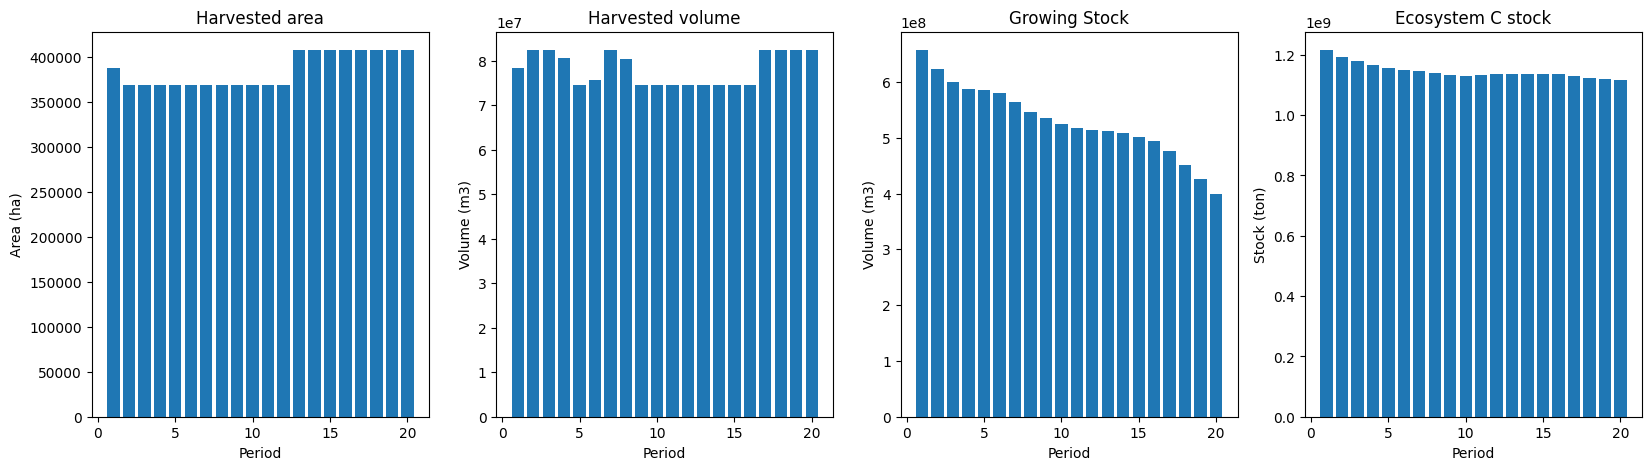

In [24]:
fm.add_null_action()
constraint = run_scenario(fm, 'base_c', 'gurobi')

running base scenario with carbon constraints
Set parameter Username
Academic license - for non-commercial use only - expires 2025-06-24
Gurobi Optimizer version 10.0.1 build v10.0.1rc0 (linux64)

CPU model: Intel Xeon Processor (Skylake, IBRS), instruction set [SSE2|AVX|AVX2|AVX512]
Thread count: 16 physical cores, 16 logical processors, using up to 16 threads

Optimize a model with 854 rows, 45499 columns and 1108881 nonzeros
Model fingerprint: 0x94996378
Coefficient statistics:
  Matrix range     [2e-10, 8e+08]
  Objective range  [9e+02, 9e+07]
  Bounds range     [0e+00, 0e+00]
  RHS range        [1e+00, 1e+20]
         Consider reformulating model or setting NumericFocus parameter
         to avoid numerical issues.
Presolve time: 0.28s
Presolved: 516 rows, 44729 columns, 896031 nonzeros

Concurrent LP optimizer: primal simplex, dual simplex, and barrier
Showing barrier log only...

Ordering time: 0.00s

Barrier statistics:
 AA' NZ     : 3.482e+04
 Factor NZ  : 4.215e+04 (roughly 2

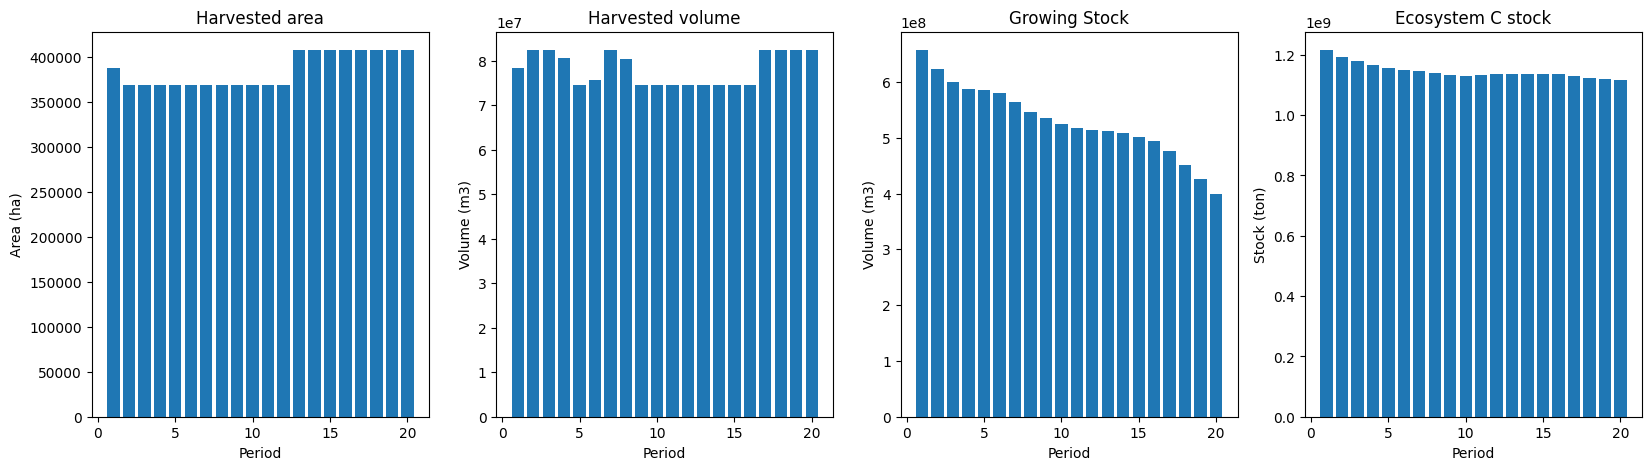

In [24]:
fm.add_null_action()
constraint = run_scenario(fm, 'base_c', 'gurobi')